In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

def resize_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img


In [13]:
def build_resnet_model(num_classes):
    # Load pre-trained ResNet50 model without top (fully connected) layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


Found 2459 images belonging to 2 classes.
Found 1277 images belonging to 2 classes.
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9085 - loss: 0.3355 - val_accuracy: 0.9856 - val_loss: 0.0497
Epoch 2/10
 1/76 ━━━━━━━━━━━━━━━━━━━━ 40s 544ms/step - accuracy: 1.0000 - loss: 0.0304

D:\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9862 - loss: 0.0356 - val_accuracy: 0.9848 - val_loss: 0.0655
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9375 - loss: 0.0349 - val_accuracy: 1.0000 - val_loss: 9.9515e-04
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9981 - loss: 0.0058 - val_accuracy: 0.9920 - val_loss: 0.0361
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9655 - val_loss: 0.1002
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9963 - loss: 0.0074 - val_accuracy: 0.9912 - val_loss: 0.0230
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 1.0000 - loss: 9.8907e-04 - val_accuracy: 0.9880 - val_loss: 0

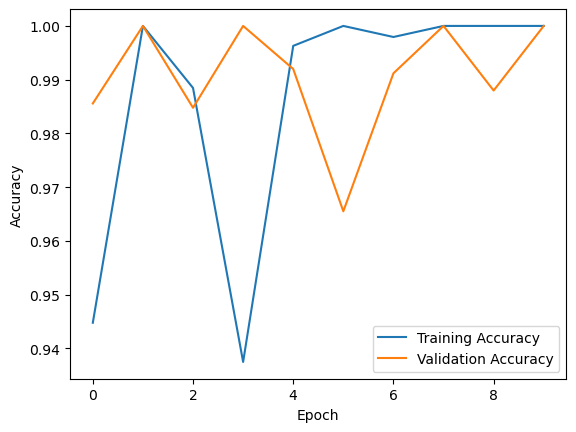

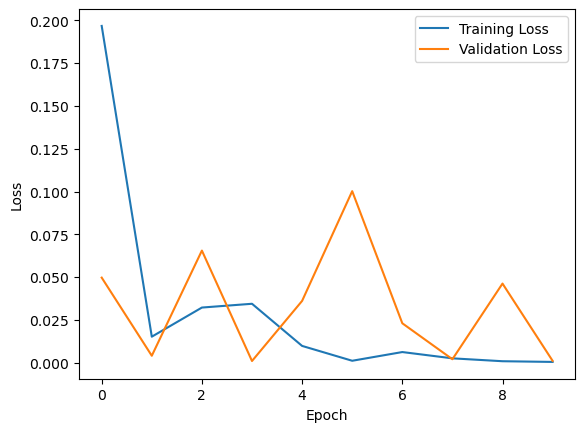

40/40 - 41s - 1s/step - accuracy: 0.9883 - loss: 0.0451
Test Accuracy: 0.9882537126541138
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 950ms/step
Confusion Matrix:
[[ 53 218]
 [203 803]]
Classification Report:
              precision    recall  f1-score   support

 nonreusable       0.21      0.20      0.20       271
    reusable       0.79      0.80      0.79      1006

    accuracy                           0.67      1277
   macro avg       0.50      0.50      0.50      1277
weighted avg       0.66      0.67      0.67      1277



In [14]:
# Step 1: Data Preparation
train_dir = r"D:\company\Dataset\train"  # Directory containing training images
test_dir = r'D:\company\Dataset\val'    # Directory containing testing images

# Image data generators for training and testing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

# Step 2: Model Building
model = build_resnet_model(num_classes=train_generator.num_classes)

# Step 3: Model Training
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size
    )

    # Step 4: Model Evaluation
    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model on the test data
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print("Test Accuracy:", test_acc)

    # Generate predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

except Exception as e:
    print("An error occurred during model training or evaluation:", e)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 1.0000 - loss: 4.8001e-04 - val_accuracy: 0.9912 - val_loss: 0.0249
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.1514e-04 - val_accuracy: 1.0000 - val_loss: 3.9544e-04
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 1.0000 - loss: 3.3505e-04 - val_accuracy: 0.9920 - val_loss: 0.0284
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4434e-04 - val_accuracy: 0.9655 - val_loss: 0.0182
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 1.0000 - loss: 2.9719e-04 - val_accuracy: 0.9912 - val_loss: 0.0297
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.3941e-05 - val_accuracy: 0.9655 - val_loss: 0.0359
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 1.0000 - loss: 2.4466e-04 - val_accuracy: 0.9912 - val_loss: 0.0302
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 3.8729e-

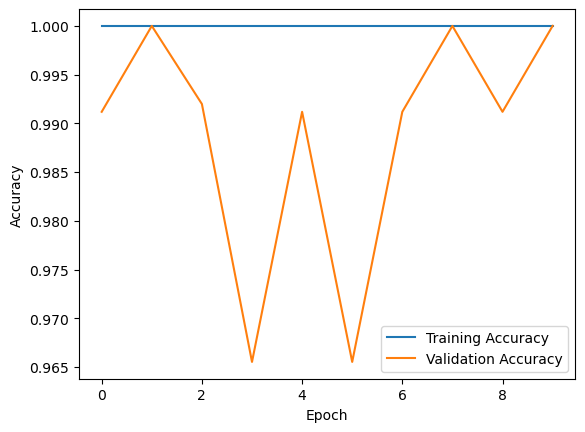

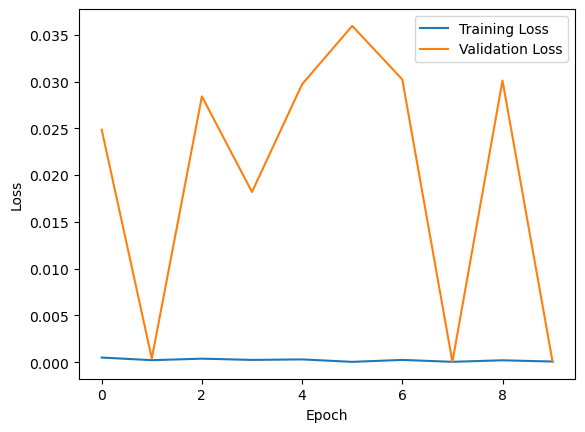

40/40 - 39s - 966ms/step - accuracy: 0.9914 - loss: 0.0295
Test Accuracy: 0.9913860559463501
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 925ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

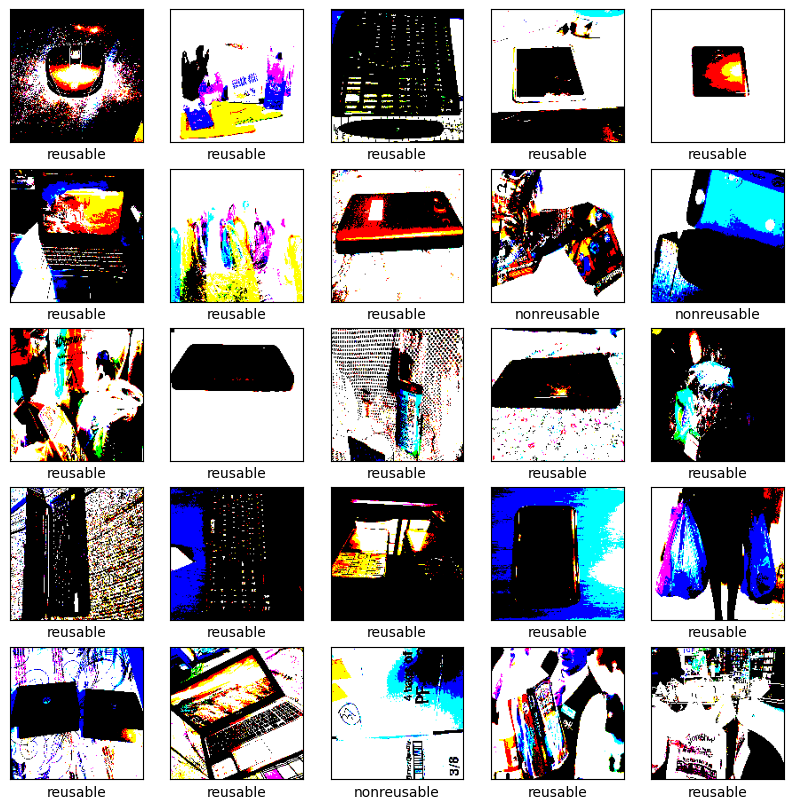

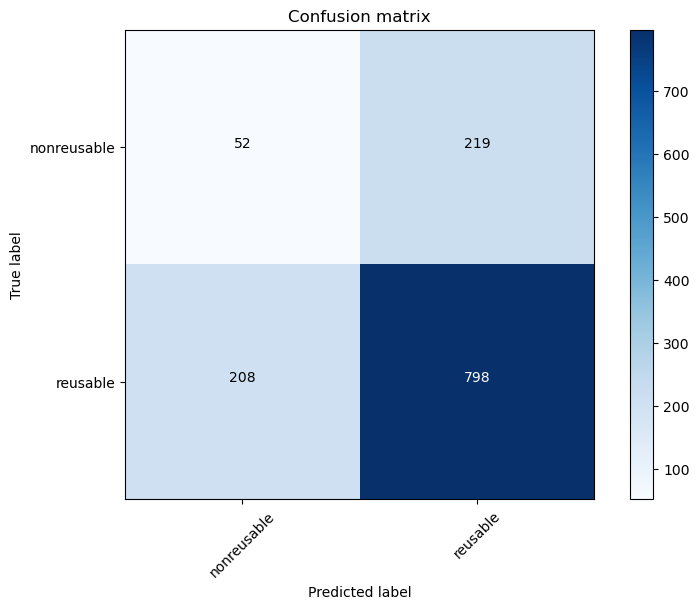

In [19]:
# Your existing code...

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size
    )

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model on the test data
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print("Test Accuracy:", test_acc)

    # Generate predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Plot processed images
    plot_processed_images(test_generator[0][0], np.argmax(test_generator[0][1], axis=1), list(test_generator.class_indices.keys()))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, list(test_generator.class_indices.keys()))

except Exception as e:
    print("An error occurred during model training or evaluation:", e)


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_input(img):
    # Preprocess the image as needed (e.g., resizing, scaling, etc.)
    img = img.resize((150, 150))  # Resize the image to the model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

def predict_image_class(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = preprocess_input(img)

    # Make predictions
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    class_probabilities = predictions[0]

    # Get the class labels from the generator
    class_labels = list(train_generator.class_indices.keys())

    # Get the predicted class name and its probability
    predicted_class_name = class_labels[predicted_class]
    probability = class_probabilities[predicted_class]

    return predicted_class_name, probability

def browse_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        predicted_class, probability = predict_image_class(file_path, model)
        show_image_and_result(file_path, predicted_class, probability)

def show_image_and_result(image_path, predicted_class, probability):
    # Load image
    img = Image.open(image_path)
    img = img.resize((300, 300))  # Resize image for display
    img_tk = ImageTk.PhotoImage(img)

    # Update image in the Tkinter window
    canvas.img = img_tk
    canvas.create_image(0, 0, anchor="nw", image=img_tk)

    # Display prediction result
    result_label.config(text=f"Predicted Class: {predicted_class}\nProbability: {probability}")

# Create Tkinter window
window = tk.Tk()
window.title("Image Classification")

# Create Browse button
browse_button = tk.Button(window, text="Browse", command=browse_image)
browse_button.pack(pady=10)

# Create canvas to display image
canvas = tk.Canvas(window, width=300, height=300)
canvas.pack()

# Create label to display prediction result
result_label = tk.Label(window, text="")
result_label.pack()

# Run Tkinter event loop
window.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
